# 提取嘴部BS

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.decomposition import SparseCoder

In [2]:
def drawPart(face_kps,drawimg,start,end,color,closed=True):
    for i in range(start,end+1):
        cv2.circle(drawimg,(face_kps[i,0],face_kps[i,1]),2,color,-1)
        if(i<end):
            cv2.line(drawimg,(face_kps[i,0],face_kps[i,1]),(face_kps[i+1,0],face_kps[i+1,1]),color,1)
        elif(closed):
            cv2.line(drawimg,(face_kps[end,0],face_kps[end,1]),(face_kps[start,0],face_kps[start,1]),color,1)
    return drawimg
def drawFace(kps):
    img = np.zeros((np.max(kps[...,0]*2),np.max(kps[...,1])*2,3),dtype='uint8')
    img = drawPart(kps,img,0,4,(255,0,0),False) # 左眉毛，非封闭区域
    img = drawPart(kps,img,5,9,(0,255,0),False) #右眉毛，非封闭区域
    img = drawPart(kps,img,10,15,(255,0,0)) # 左眼
    img = drawPart(kps,img,16,21,(0,255,0)) # 右眼
    img = drawPart(kps,img,22,25,(0,0,255),False) # 鼻梁，非封闭区域
    img = drawPart(kps,img,26,30,(0,0,255),False) # 鼻子，非封闭区域
    img = drawPart(kps,img,31,42,(0,255,255)) # 外嘴唇
    img = drawPart(kps,img,43,50,(255,0,255)) # 内嘴唇
    img = drawPart(kps,img,51,67,(255,255,0),False) # 脸轮廓，非封闭区域
    return img

In [3]:
# 加载keypose表情基，测试表情关键点
keypose = np.load("keypose.npy")
testpose = np.load("test.npy")

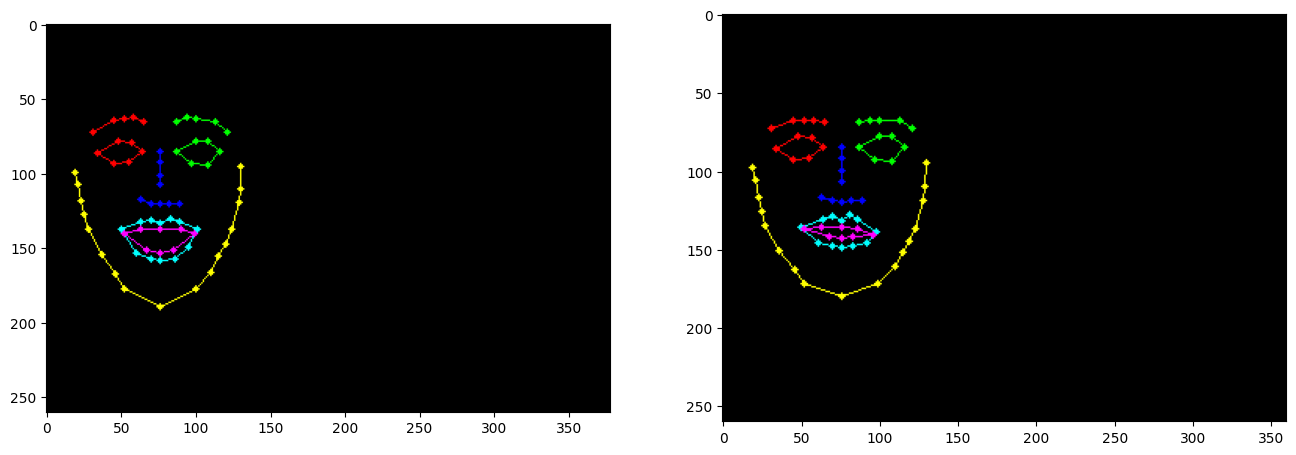

In [4]:
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(drawFace(testpose[0]))
plt.subplot(122)
plt.imshow(drawFace(testpose[1]))

In [5]:
testpose = testpose[1]

In [6]:
'''
第一步将表情基分开
0-7为嘴的动作
'''
keyposes_mouth = keypose[0:8]

width_points = testpose[67][0]-testpose[51][0] #脸宽

In [7]:
'''
将表情基的人脸关键点与当前表情关键点对齐
可以用于处理局部关键点，源码中分别处理眼、嘴
'''
def shiftKeyPoses(new_width, centroid, keyposes, config):   
    #Scale keypose based on head width to accomodate for translation or different video size.
    width_keypose = (keyposes[0][67][0]-keyposes[0][51][0]) # 表情基中第一个姿态的人脸宽度
    width_fac = width_keypose/new_width # 表情基脸宽/真人脸宽
    
    keyposes = np.divide(keyposes, [width_fac,width_fac]).astype(int) # 依据比例系数，将所有表情基关键点缩放到真人面部大小
    
    new_poses = []
    
    for i in range(keyposes.shape[0]): # 遍历所有的表情基
        #For brows we take average of eyes points
        if config == 'brows': 
            keypose = np.array(keyposes[i][10:22])
        #Fo mouth we take average of mouth points
        if config == 'mouth':
            keypose = np.array(keyposes[i][31:51])
            
        centroid_keypose = keypose.mean(0) #表情基中眉毛或者嘴部的中心
        delta = centroid_keypose-centroid # 表情基眉毛或嘴中心与真人眉毛或嘴中心的偏移量
        
        new_pose = keyposes[i]-delta.astype(int) # 利用中心偏移量 重新调整表情基的位置
        new_poses.append(new_pose) # 将新的表情基加入数组中返回
        
    return np.array(new_poses)

In [8]:
'''
嘴部BS
'''
# 对齐keypose和真人嘴部关键点
mouth_center = testpose[31:51].mean(0)
shift_kps_mouth = shiftKeyPoses(width_points,mouth_center,keyposes_mouth,"mouth")
# 重组嘴部坐标，便于计算
target_mouth = testpose[31:51].reshape((1,-1))
dict_2d_mouth = []
for i in range(shift_kps_mouth.shape[0]):
    dict_2d_mouth.append(shift_kps_mouth[i][31:51])
dict_2d_mouth = np.array(dict_2d_mouth).reshape(shift_kps_mouth.shape[0],-1)
# 提取嘴部运动的系数
coder = SparseCoder(dictionary=dict_2d_mouth.astype("float32"),transform_n_nonzero_coefs=None,transform_alpha=10,transform_algorithm='lasso_lars')
coeffs = coder.transform(target_mouth.astype("float32"))

# 验证BS

In [9]:
def getVerts(objfile):
    vertices = []
    for line in open(objfile, "r"):
        values = line.split()
        if(values==[]):
            continue
        if(values=='#'):
            continue
        if(values[0]=='v'):
            vertices.append([float(values[1]),float(values[2]),float(values[3])])    
    return np.array(vertices)

def writeResult(verts):
    f = open("./data/Basis.obj",'r')
    contents = f.readlines()
    i = 0
    for idx in range(len(contents)):
        if 'v ' in contents[idx]:
            contents[idx] = 'v {0} {1} {2} \n'.format(str(verts[i][0]),str(verts[i][1]),str(verts[i][2]))
            i = i + 1
    fn = open("./test/result.obj",'w')
    fn.writelines(contents)
    fn.close()
    f.close()

In [10]:
# 获取BS偏移量
# 0：Neutral
basicVerts = getVerts('./data/Basis.obj')
# 1：Jaw Open
jawopenVerts = getVerts('./data/jawOpen.obj')
# 2：Closed Smile
closesmileVerts = getVerts('./data/mouthSmile.obj')
# 3：Smile Left
smileleftVerts = getVerts('./data/mouthSmileLeft.obj')
# 4：Smile Right
smilerightVerts = getVerts('./data/mouthSmileRight.obj')
# 5：Mouth Frown
mouthfrownVerts = getVerts('./data/mouthFrown.obj')
# 6：Lip Funnel
lipfunnelVerts = getVerts('./data/mouthFunnel.obj')
# 7：Lip Pucker
lippuckerVerts = getVerts('./data/mouthPucker.obj')

offset = []
offset.append(basicVerts-basicVerts)
offset.append(jawopenVerts-basicVerts)
offset.append(closesmileVerts-basicVerts)
offset.append(smileleftVerts-basicVerts)
offset.append(smilerightVerts-basicVerts)
offset.append(mouthfrownVerts-basicVerts)
offset.append(lipfunnelVerts-basicVerts)
offset.append(lippuckerVerts-basicVerts)

offset = np.array(offset,dtype="float32")

In [11]:
# 根据系数组合BS
newVert = basicVerts
for i in range(offset.shape[0]):
    newVert = newVert + coeffs[0,i]*offset[i]
writeResult(newVert)